<a href="https://colab.research.google.com/github/rizkyfauziilmi/TUGAS_UAS_ML/blob/main/clustering_data_kecil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup Rapids (GPU)

In [409]:
!nvidia-smi

Sun Jun  8 10:01:21 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   77C    P0             32W /   70W |     170MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [410]:
# This get the RAPIDS-Colab install files and test check your GPU.  Run this and the next cell only.
# Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible, it will warn you and give you remediation steps.
# !git clone https://github.com/rapidsai/rapidsai-csp-utils.git
# !python rapidsai-csp-utils/colab/pip-install.py

# Setup package lain

In [411]:
!pip install kagglehub hvplot holoviews bokeh

# 📊 Tugas Besar Pembelajaran Mesin - Clustering (Kecil)

## 👨‍🏫 Universitas Widyatama  
**Mata Kuliah:** Pembelajaran Mesin  
**Kelompok:**  
- Danang (23508018)  
- Iwan (23508019)  
- Sari (23508020)

---

### 📊 Tabel Kategori Ukuran Dataset

| Kategori       | Jumlah Baris (Row)      |
|----------------|--------------------------|
| **Kecil**       | < 1 mb                  |
| **Sedang**      | 1–2 mb           |
| **Besar**       | 2-3 mb         |
| **Sangat Besar**| 3-5 mb                |

---

## 📁 Struktur Notebook
1. 📥 **Import Library & Persiapan Lingkungan**
2. 📂 **Load Dataset**
3. 🧼 **Preprocessing & Normalisasi**
4. 🔁 **Implementasi K-Means (CPU & GPU)**
5. ⚖️ **Komparasi**
6. 🧪 **Evaluasi**
7. 📈 **Visualisasi Cluster**
8. 📊 **Significant Test: CPU vs GPU**
9. 📝 **Kesimpulan Akhir**

---

### 1. 📥 **Import Library & Persiapan Lingkungan**

- Download dataset dari Kaggle.

In [412]:
import kagglehub

path_df1 = kagglehub.dataset_download("zusmani/uberdrives")
path_df2 = kagglehub.dataset_download("rakeshkapilavai/extrovert-vs-introvert-behavior-data")
path_df3 = kagglehub.dataset_download("jayaantanaath/student-habits-vs-academic-performance")
path_df4 = kagglehub.dataset_download("adilshamim8/social-media-addiction-vs-relationships")
path_df5 = kagglehub.dataset_download("atharvasoundankar/taco-sales-dataset-20242025")

---

### 2. 📂 **Load Dataset**

In [413]:
import cudf

df1 = cudf.read_csv(path_df1 + "/My Uber Drives - 2016.csv")
df2 = cudf.read_csv(path_df2 + "/personality_dataset.csv")
df3 = cudf.read_csv(path_df3 + "/student_habits_performance.csv")
df4 = cudf.read_csv(path_df4 + "/Students Social Media Addiction.csv")
df5 = cudf.read_csv(path_df5 + "/taco_sales_(2024-2025).csv")

display(df1.head())
display(df2.head())
display(df3.head())
display(df4.head())
display(df5.head())

,START_DATE*,END_DATE*,CATEGORY*,START*,STOP*,MILES*,PURPOSE*
0,1/1/2016 21:11,1/1/2016 21:17,Business,Fort Pierce,Fort Pierce,5.1,Meal/Entertain
1,1/2/2016 1:25,1/2/2016 1:37,Business,Fort Pierce,Fort Pierce,5.0,<NA>
2,1/2/2016 20:25,1/2/2016 20:38,Business,Fort Pierce,Fort Pierce,4.8,Errand/Supplies
3,1/5/2016 17:31,1/5/2016 17:45,Business,Fort Pierce,Fort Pierce,4.7,Meeting
4,1/6/2016 14:42,1/6/2016 15:49,Business,Fort Pierce,West Palm Beach,63.7,Customer Visit


,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,4.0,No,4.0,6.0,No,13.0,5.0,Extrovert
1,9.0,Yes,0.0,0.0,Yes,0.0,3.0,Introvert
2,9.0,Yes,1.0,2.0,Yes,5.0,2.0,Introvert
3,0.0,No,6.0,7.0,No,14.0,8.0,Extrovert
4,3.0,No,9.0,4.0,No,8.0,5.0,Extrovert


,student_id,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,parental_education_level,internet_quality,mental_health_rating,extracurricular_participation,exam_score
0,S1000,23,Female,0.0,1.2,1.1,No,85.0,8.0,Fair,6,Master,Average,8,Yes,56.2
1,S1001,20,Female,6.9,2.8,2.3,No,97.3,4.6,Good,6,High School,Average,8,No,100.0
2,S1002,21,Male,1.4,3.1,1.3,No,94.8,8.0,Poor,1,High School,Poor,1,No,34.3
3,S1003,23,Female,1.0,3.9,1.0,No,71.0,9.2,Poor,4,Master,Good,1,Yes,26.8
4,S1004,19,Female,5.0,4.4,0.5,No,90.9,4.9,Fair,3,Master,Good,1,No,66.4


,Student_ID,Age,Gender,Academic_Level,Country,Avg_Daily_Usage_Hours,Most_Used_Platform,Affects_Academic_Performance,Sleep_Hours_Per_Night,Mental_Health_Score,Relationship_Status,Conflicts_Over_Social_Media,Addicted_Score
0,1,19,Female,Undergraduate,Bangladesh,5.2,Instagram,Yes,6.5,6,In Relationship,3,8
1,2,22,Male,Graduate,India,2.1,Twitter,No,7.5,8,Single,0,3
2,3,20,Female,Undergraduate,USA,6.0,TikTok,Yes,5.0,5,Complicated,4,9
3,4,18,Male,High School,UK,3.0,YouTube,No,7.0,7,Single,1,4
4,5,21,Male,Graduate,Canada,4.5,Facebook,Yes,6.0,6,In Relationship,2,7


,Order ID,Restaurant Name,Location,Order Time,Delivery Time,Delivery Duration (min),Taco Size,Taco Type,Toppings Count,Distance (km),Price ($),Tip ($),Weekend Order
0,770487,El Taco Loco,New York,01-08-2024 14:55,01-08-2024 15:36,41,Regular,Chicken Taco,5,3.01,9.25,2.22,False
1,671858,El Taco Loco,San Antonio,23-11-2024 17:11,23-11-2024 17:25,14,Regular,Beef Taco,1,6.20,4.25,3.01,True
2,688508,Taco Haven,Austin,21-11-2024 20:24,21-11-2024 21:02,38,Large,Pork Taco,2,20.33,7.00,0.02,False
3,944962,Spicy Taco House,Dallas,21-09-2024 06:43,21-09-2024 07:28,45,Regular,Chicken Taco,2,3.00,5.50,1.90,True
4,476417,Casa del Taco,San Antonio,24-07-2024 11:01,24-07-2024 11:16,15,Large,Pork Taco,0,24.34,4.50,1.14,False


---

### 3. 🧼 **Preprocessing & Normalisasi**

- Hapus Kolom yang Tidak digunakan untuk clustering

Dalam proses clustering, penting untuk memilih fitur yang relevan dan informatif agar algoritma dapat mengelompokkan data secara akurat. Fitur seperti ID unik, waktu mentah, dan label eksplisit sering kali tidak berguna atau bahkan mengganggu. Oleh karena itu, dilakukan proses pembersihan (dropping) terhadap kolom-kolom tersebut.

In [414]:
df1 = df1.drop(columns=['START_DATE*', 'END_DATE*', 'START*', 'STOP*'])
df2 = df2.drop(columns=['Personality'])
df3 = df3.drop(columns=['student_id', 'exam_score'])
df4 = df4.drop(columns=['Student_ID'])
df5 = df5.drop(columns=['Order ID', 'Restaurant Name', 'Location', 'Order Time', 'Delivery Time'])

- Cek dan Tangani Missing Values (Null / NaN)

In [415]:
print("Missing Values Dataset 1:")
print(df1.isnull().sum())
print("Missing Values Dataset 2:")
print(df2.isnull().sum())
print("Missing Values Dataset 3:")
print(df3.isnull().sum())
print("Missing Values Dataset 4:")
print(df4.isnull().sum())
print("Missing Values Dataset 5:")
print(df5.isnull().sum())

Missing Values Dataset 1:
CATEGORY*      1
MILES*         0
PURPOSE*     503
dtype: int64
Missing Values Dataset 2:
Time_spent_Alone             63
Stage_fear                   73
Social_event_attendance      62
Going_outside                66
Drained_after_socializing    52
Friends_circle_size          77
Post_frequency               65
dtype: int64
Missing Values Dataset 3:
age                              0
gender                           0
study_hours_per_day              0
social_media_hours               0
netflix_hours                    0
part_time_job                    0
attendance_percentage            0
sleep_hours                      0
diet_quality                     0
exercise_frequency               0
parental_education_level         0
internet_quality                 0
mental_health_rating             0
extracurricular_participation    0
dtype: int64
Missing Values Dataset 4:
Age                             0
Gender                          0
Academic_Level          

In [416]:
import cupy as cp

def handle_missing_values(df: cudf.DataFrame) -> cudf.DataFrame:
    """
    Deteksi dan imputasi missing value berdasarkan tipe data:
    - Numerik: diisi median
    - Kategorikal: diisi modus
    """
    df_filled = df.copy()

    for col in df_filled.columns:
        if df_filled[col].isnull().sum() > 0:
            if df_filled[col].dtype in [cp.float64, cp.int64]:
                # Imputasi numerik dengan rata-rata
                median_val = df_filled[col].mean()
                df_filled[col].fillna(median_val, inplace=True)
                print(f"Imputasi kolom numerik '{col}' dengan mean: {median_val}")
            else:
                # Imputasi kategorikal dengan modus
                mode_val = df_filled[col].mode()[0]
                df_filled[col].fillna(mode_val, inplace=True)
                print(f"Imputasi kolom kategorikal '{col}' dengan modus: {mode_val}")

    return df_filled

In [417]:
df1 = handle_missing_values(df1)
df2 = handle_missing_values(df2)
df3 = handle_missing_values(df3)
df4 = handle_missing_values(df4)
df5 = handle_missing_values(df5)

Imputasi kolom kategorikal 'CATEGORY*' dengan modus: Business
Imputasi kolom kategorikal 'PURPOSE*' dengan modus: Meeting
Imputasi kolom numerik 'Time_spent_Alone' dengan mean: 4.505816002819881
Imputasi kolom kategorikal 'Stage_fear' dengan modus: No
Imputasi kolom numerik 'Social_event_attendance' dengan mean: 3.963354474982382
Imputasi kolom numerik 'Going_outside' dengan mean: 3.0
Imputasi kolom kategorikal 'Drained_after_socializing' dengan modus: No
Imputasi kolom numerik 'Friends_circle_size' dengan mean: 6.268862911795962
Imputasi kolom numerik 'Post_frequency' dengan mean: 3.564726631393298


In [418]:
print("Missing Values Dataset 1:")
print(df1.isnull().sum())
print("Missing Values Dataset 2:")
print(df2.isnull().sum())
print("Missing Values Dataset 3:")
print(df3.isnull().sum())
print("Missing Values Dataset 4:")
print(df4.isnull().sum())
print("Missing Values Dataset 5:")
print(df5.isnull().sum())

Missing Values Dataset 1:
CATEGORY*    0
MILES*       0
PURPOSE*     0
dtype: int64
Missing Values Dataset 2:
Time_spent_Alone             0
Stage_fear                   0
Social_event_attendance      0
Going_outside                0
Drained_after_socializing    0
Friends_circle_size          0
Post_frequency               0
dtype: int64
Missing Values Dataset 3:
age                              0
gender                           0
study_hours_per_day              0
social_media_hours               0
netflix_hours                    0
part_time_job                    0
attendance_percentage            0
sleep_hours                      0
diet_quality                     0
exercise_frequency               0
parental_education_level         0
internet_quality                 0
mental_health_rating             0
extracurricular_participation    0
dtype: int64
Missing Values Dataset 4:
Age                             0
Gender                          0
Academic_Level                  0
Cou

- Cek Outlier

In [419]:
import hvplot.cudf
import holoviews as hv
hv.extension('bokeh')

def plot_boxplots_holoviews(dataframe, before_outlier=True):
    """
    Menampilkan boxplot interaktif dari cuDF DataFrame menggunakan Holoviews + Bokeh.
    """
    numeric_columns = dataframe.select_dtypes(include=['float64', 'int64']).columns.tolist()

    # Seragamkan tipe data agar melt() tidak error
    df_for_plot = dataframe[numeric_columns].astype('float64')

    melted = df_for_plot.melt(var_name='Kolom', value_name='Nilai')

    title = f"Boxplot Interaktif {'(Sebelum Outlier)' if before_outlier else '(Setelah Outlier)'}"
    return melted.hvplot.box(y='Nilai', by='Kolom', width=800, height=400, title=title)


def handle_outliers_iqr(dataframe: cudf.DataFrame) -> cudf.DataFrame:
    """
    Mendeteksi dan menangani outlier menggunakan IQR dan visualisasi Holoviews.
    """
    numeric_columns = dataframe.select_dtypes(include=['float64', 'int64']).columns
    total_outliers = 0
    columns_with_outliers = []

    if numeric_columns.empty:
        print("Tidak ada kolom numerik.")
        return dataframe

    df_no_outlier = dataframe.copy()

    print("Menampilkan boxplot sebelum outlier...")
    display(plot_boxplots_holoviews(dataframe, before_outlier=True))

    print("Mendeteksi outlier...")
    for col in numeric_columns:
        Q1 = dataframe[col].quantile(0.25)
        Q3 = dataframe[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        n_outliers = len(dataframe[(dataframe[col] < lower) | (dataframe[col] > upper)])
        total_outliers += n_outliers
        if n_outliers > 0:
            columns_with_outliers.append(col)
            lower_clip = dataframe[col].quantile(0.05)
            upper_clip = dataframe[col].quantile(0.95)
            df_no_outlier[col] = dataframe[col].clip(lower=lower_clip, upper=upper_clip)
            print(f"{n_outliers} outlier di kolom '{col}', sudah di-clip.")
        else:
            print(f"Tidak ada outlier di kolom '{col}'.")

    if total_outliers == 0:
        print("Tidak ada outlier yang perlu ditangani.")

    print("Menampilkan boxplot setelah penanganan outlier...")
    display(plot_boxplots_holoviews(df_no_outlier, before_outlier=False))

    return df_no_outlier

In [420]:
df1 = handle_outliers_iqr(df1)
df2 = handle_outliers_iqr(df2)
df3 = handle_outliers_iqr(df3)
df4 = handle_outliers_iqr(df4)
df5 = handle_outliers_iqr(df5)

Menampilkan boxplot sebelum outlier...


:BoxWhisker   [Kolom]   (Nilai)

Mendeteksi outlier...
78 outlier di kolom 'MILES*', sudah di-clip.
Menampilkan boxplot setelah penanganan outlier...


:BoxWhisker   [Kolom]   (Nilai)

Menampilkan boxplot sebelum outlier...


:BoxWhisker   [Kolom]   (Nilai)

Mendeteksi outlier...
Tidak ada outlier di kolom 'Time_spent_Alone'.
Tidak ada outlier di kolom 'Social_event_attendance'.
Tidak ada outlier di kolom 'Going_outside'.
Tidak ada outlier di kolom 'Friends_circle_size'.
Tidak ada outlier di kolom 'Post_frequency'.
Tidak ada outlier yang perlu ditangani.
Menampilkan boxplot setelah penanganan outlier...


:BoxWhisker   [Kolom]   (Nilai)

Menampilkan boxplot sebelum outlier...


:BoxWhisker   [Kolom]   (Nilai)

Mendeteksi outlier...
Tidak ada outlier di kolom 'age'.
7 outlier di kolom 'study_hours_per_day', sudah di-clip.
5 outlier di kolom 'social_media_hours', sudah di-clip.
4 outlier di kolom 'netflix_hours', sudah di-clip.
3 outlier di kolom 'attendance_percentage', sudah di-clip.
2 outlier di kolom 'sleep_hours', sudah di-clip.
Tidak ada outlier di kolom 'exercise_frequency'.
Tidak ada outlier di kolom 'mental_health_rating'.
Menampilkan boxplot setelah penanganan outlier...


:BoxWhisker   [Kolom]   (Nilai)

Menampilkan boxplot sebelum outlier...


:BoxWhisker   [Kolom]   (Nilai)

Mendeteksi outlier...
Tidak ada outlier di kolom 'Age'.
3 outlier di kolom 'Avg_Daily_Usage_Hours', sudah di-clip.
Tidak ada outlier di kolom 'Sleep_Hours_Per_Night'.
Tidak ada outlier di kolom 'Mental_Health_Score'.
Tidak ada outlier di kolom 'Conflicts_Over_Social_Media'.
Tidak ada outlier di kolom 'Addicted_Score'.
Menampilkan boxplot setelah penanganan outlier...


:BoxWhisker   [Kolom]   (Nilai)

Menampilkan boxplot sebelum outlier...


:BoxWhisker   [Kolom]   (Nilai)

Mendeteksi outlier...
Tidak ada outlier di kolom 'Delivery Duration (min)'.
Tidak ada outlier di kolom 'Toppings Count'.
Tidak ada outlier di kolom 'Distance (km)'.
Tidak ada outlier di kolom 'Price ($)'.
3 outlier di kolom 'Tip ($)', sudah di-clip.
Menampilkan boxplot setelah penanganan outlier...


:BoxWhisker   [Kolom]   (Nilai)

- Ubah Data Kategori ke Numerik

In [421]:
def check_categorical_columns(df: cudf.DataFrame) -> None:
    """
    Print jumlah dan nama-nama kolom kategorikal dalam DataFrame,
    termasuk kolom bertipe bool.
    """
    # Cek kolom object, category, dan bool
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    num_categorical = len(categorical_cols)

    bool_cols = df.select_dtypes(include=['bool']).columns
    num_bool = len(bool_cols)

    for col in bool_cols:
        df[col] = df[col].astype('int8')
        print(f"Konversi kolom boolean '{col}' ke int8")

    print(f"Jumlah kolom kategorikal (termasuk bool): {num_categorical + num_bool}")
    print(f"Nama kolom kategorikal (termasuk bool): {list(categorical_cols) + list(bool_cols)}")

In [422]:
check_categorical_columns(df1)
check_categorical_columns(df2)
check_categorical_columns(df3)
check_categorical_columns(df4)
check_categorical_columns(df5)

Jumlah kolom kategorikal (termasuk bool): 2
Nama kolom kategorikal (termasuk bool): ['CATEGORY*', 'PURPOSE*']
Jumlah kolom kategorikal (termasuk bool): 2
Nama kolom kategorikal (termasuk bool): ['Stage_fear', 'Drained_after_socializing']
Jumlah kolom kategorikal (termasuk bool): 6
Nama kolom kategorikal (termasuk bool): ['gender', 'part_time_job', 'diet_quality', 'parental_education_level', 'internet_quality', 'extracurricular_participation']
Jumlah kolom kategorikal (termasuk bool): 6
Nama kolom kategorikal (termasuk bool): ['Gender', 'Academic_Level', 'Country', 'Most_Used_Platform', 'Affects_Academic_Performance', 'Relationship_Status']
Konversi kolom boolean 'Weekend Order' ke int8
Jumlah kolom kategorikal (termasuk bool): 3
Nama kolom kategorikal (termasuk bool): ['Taco Size', 'Taco Type', 'Weekend Order']


In [423]:
from cuml.preprocessing import OrdinalEncoder

def encode_categorical_columns(df: cudf.DataFrame) -> cudf.DataFrame:
    df_encoded = df.copy()
    cat_cols = df_encoded.select_dtypes(include=['object', 'category']).columns

    if len(cat_cols) > 0:
        encoder = OrdinalEncoder()
        df_encoded[cat_cols] = encoder.fit_transform(df_encoded[cat_cols])
        print(f"Encoded columns: {list(cat_cols)}")
    else:
        print("No categorical columns found.")

    return df_encoded

In [424]:
df1 = encode_categorical_columns(df1)
df2 = encode_categorical_columns(df2)
df3 = encode_categorical_columns(df3)
df4 = encode_categorical_columns(df4)
df5 = encode_categorical_columns(df5)

Encoded columns: ['CATEGORY*', 'PURPOSE*']
Encoded columns: ['Stage_fear', 'Drained_after_socializing']
Encoded columns: ['gender', 'part_time_job', 'diet_quality', 'parental_education_level', 'internet_quality', 'extracurricular_participation']
Encoded columns: ['Gender', 'Academic_Level', 'Country', 'Most_Used_Platform', 'Affects_Academic_Performance', 'Relationship_Status']
Encoded columns: ['Taco Size', 'Taco Type']


In [425]:
check_categorical_columns(df1)
check_categorical_columns(df2)
check_categorical_columns(df3)
check_categorical_columns(df4)
check_categorical_columns(df5)

Jumlah kolom kategorikal (termasuk bool): 0
Nama kolom kategorikal (termasuk bool): []
Jumlah kolom kategorikal (termasuk bool): 0
Nama kolom kategorikal (termasuk bool): []
Jumlah kolom kategorikal (termasuk bool): 0
Nama kolom kategorikal (termasuk bool): []
Jumlah kolom kategorikal (termasuk bool): 0
Nama kolom kategorikal (termasuk bool): []
Jumlah kolom kategorikal (termasuk bool): 0
Nama kolom kategorikal (termasuk bool): []


- Pastikan Semua Kolom Bertipe Numerik

In [426]:
def is_all_numeric(df: cudf.DataFrame):
    """
    Mengembalikan True jika semua kolom dalam DataFrame bertipe numerik.
    Jika ada kolom non-numerik, mengembalikan False dan mencetak nama kolom tersebut.
    """
    non_numeric_cols = df.select_dtypes(exclude=['number']).columns

    if len(non_numeric_cols) == 0:
        print("Semua kolom bertipe numerik.")
    else:
        print("Ditemukan kolom non-numerik:")
        print(list(non_numeric_cols))

In [427]:
is_all_numeric(df1)
is_all_numeric(df2)
is_all_numeric(df3)
is_all_numeric(df4)
is_all_numeric(df5)

Semua kolom bertipe numerik.
Semua kolom bertipe numerik.
Semua kolom bertipe numerik.
Semua kolom bertipe numerik.
Semua kolom bertipe numerik.


- normalisasi kolom

In [428]:
from cuml.preprocessing import StandardScaler

def normalize_columns(df: cudf.DataFrame):
  scaler = StandardScaler()
  columns_to_normalize = df.select_dtypes(include=['number']).columns
  df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])
  return df

In [429]:
df1 = normalize_columns(df1)
df2 = normalize_columns(df2)
df3 = normalize_columns(df3)
df4 = normalize_columns(df4)
df5 = normalize_columns(df5)

In [430]:
print("Dataset 1 setelah normalisasi:")
display(df1.head())
print("Dataset 2 setelah normalisasi:")
display(df2.head())
print("Dataset 3 setelah normalisasi:")
display(df3.head())
print("Dataset 4 setelah normalisasi:")
display(df4.head())
print("Dataset 5 setelah normalisasi:")
display(df5.head())

Dataset 1 setelah normalisasi:


,CATEGORY*,MILES*,PURPOSE*
0,-0.267137,-0.422849,-0.256794
1,-0.267137,-0.437409,0.479816
2,-0.267137,-0.466531,-0.993403
3,-0.267137,-0.481092,0.479816
4,-0.267137,2.929773,-1.730013


Dataset 2 setelah normalisasi:


,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency
0,-0.147014,-0.972784,0.012759,1.350613,-0.970772,1.590680,0.496104
1,1.306226,1.027977,-1.379944,-1.350613,1.030108,-1.481437,-0.195199
2,1.306226,1.027977,-1.031768,-0.450204,1.030108,-0.299853,-0.540850
3,-1.309607,-0.972784,0.709111,1.800817,-0.970772,1.826996,1.533059
4,-0.437663,-0.972784,1.753638,0.450204,-0.970772,0.409096,0.496104


Dataset 3 setelah normalisasi:


,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,parental_education_level,internet_quality,mental_health_rating,extracurricular_participation
0,1.084551,-0.976163,-1.818626,-1.204230,-0.679318,-0.523341,0.076177,1.369455,-1.000902,1.461166,1.066464,-1.089750,0.900186,1.464464
1,-0.215870,-0.976163,1.823830,0.273183,0.493099,-0.523341,1.442126,-1.677064,0.337202,1.461166,0.001065,-1.089750,0.900186,-0.682844
2,0.217604,0.763878,-1.595619,0.550198,-0.483915,-0.523341,1.164494,1.369455,1.675307,-1.008689,0.001065,1.737098,-1.559339,-0.682844
3,1.084551,-0.976163,-1.818626,1.288904,-0.777019,-0.523341,-1.478562,1.817473,1.675307,0.473224,1.066464,0.323674,-1.559339,1.464464
4,-0.649344,-0.976163,1.080471,1.750595,-1.265526,-0.523341,0.731388,-1.408254,-1.000902,-0.020747,1.066464,0.323674,-1.559339,-0.682844


Dataset 4 setelah normalisasi:


,Age,Gender,Academic_Level,Country,Avg_Daily_Usage_Hours,Most_Used_Platform,Affects_Academic_Performance,Sleep_Hours_Per_Night,Mental_Health_Score,Relationship_Status,Conflicts_Over_Social_Media,Addicted_Score
0,-1.186915,-0.998583,0.980022,-1.575642,0.244843,-0.744546,0.745849,-0.327638,-0.205520,-0.855297,0.157063,0.985550
1,0.958662,1.001419,-1.061087,-0.627893,-1.776122,1.036805,-1.340753,0.560423,1.605628,0.857726,-2.976790,-2.166958
2,-0.471723,-0.998583,0.980022,1.431011,0.924159,0.739913,0.745849,-1.659730,-1.111095,-2.568320,1.201681,1.616052
3,-1.902108,1.001419,-0.040533,1.398330,-1.623276,2.224372,-1.340753,0.116393,0.700054,0.857726,-1.932172,-1.536456
4,0.243470,1.001419,-1.061087,-1.314194,-0.349559,-1.041438,0.745849,-0.771668,-0.205520,-0.855297,-0.887554,0.355048


Dataset 5 setelah normalisasi:


,Delivery Duration (min),Taco Size,Taco Type,Toppings Count,Distance (km),Price ($),Tip ($),Weekend Order
0,-0.427724,0.996008,-0.723448,1.439854,-1.409700,1.014192,0.412937,-0.615882
1,-1.590719,0.996008,-1.444014,-0.890950,-0.962840,-1.151265,1.159762,1.623688
2,-0.556945,-1.004008,0.717684,-0.308249,1.016513,0.039736,-1.478231,-0.615882
3,-0.255428,0.996008,-0.723448,-0.308249,-1.411101,-0.609901,0.110426,1.623688
4,-1.547645,-1.004008,0.717684,-1.473650,1.578241,-1.042992,-0.608038,-0.615882


- membuat similarity matrix

In [431]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_similarity_matrix(similarity_cudf, max_items=100, cmap='viridis', annot=False):
    """
    Visualisasikan similarity matrix dari cuDF DataFrame menggunakan heatmap.

    Parameters:
        similarity_cudf (cudf.DataFrame): Similarity matrix dalam format cuDF DataFrame.
        max_items (int): Maksimal jumlah baris/kolom yang divisualisasikan (default: 100).
        cmap (str): Colormap untuk heatmap (default: 'viridis').
        annot (bool): Tampilkan nilai pada setiap sel (default: False).
    """
    # Konversi ke pandas DataFrame
    similarity_pd = similarity_cudf.to_pandas()

    # Jika matrix terlalu besar, ambil subset
    if similarity_pd.shape[0] > max_items or similarity_pd.shape[1] > max_items:
        similarity_pd = similarity_pd.iloc[:max_items, :max_items]

    plt.figure(figsize=(10, 8))
    sns.heatmap(similarity_pd, cmap=cmap, annot=annot, fmt=".2f")
    plt.title('Similarity Matrix Heatmap')
    plt.xlabel('Item')
    plt.ylabel('Item')
    plt.show()


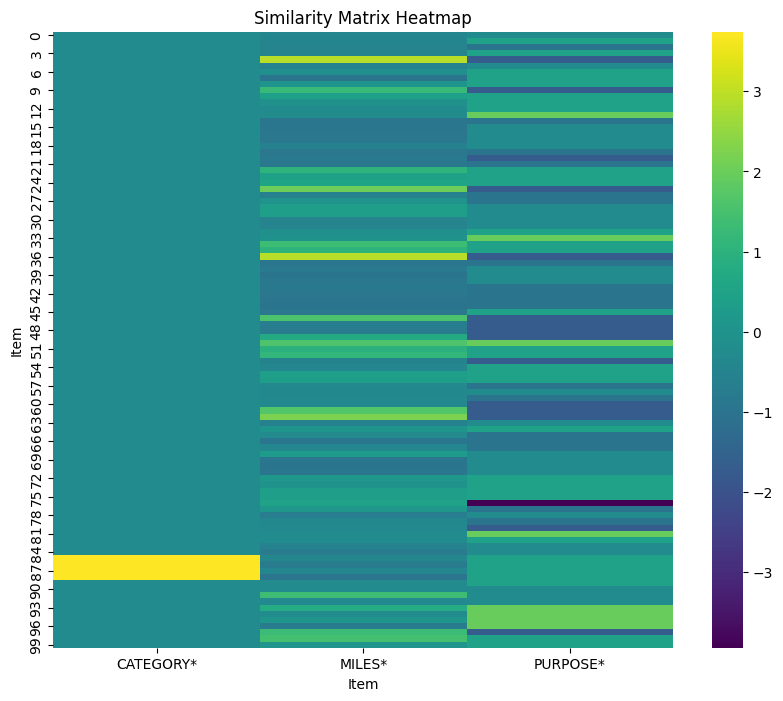

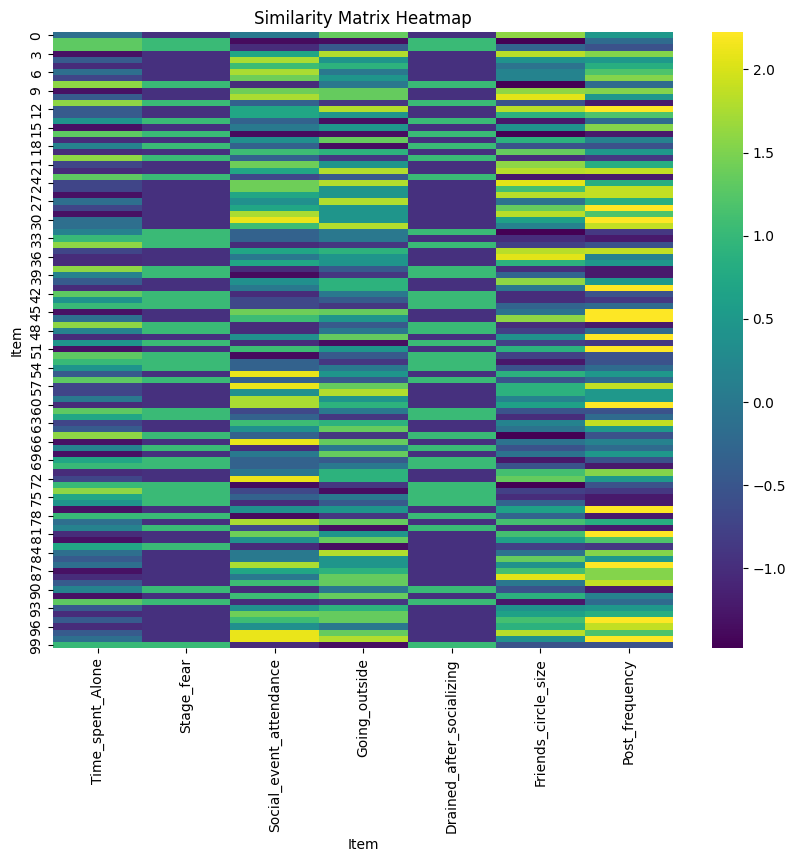

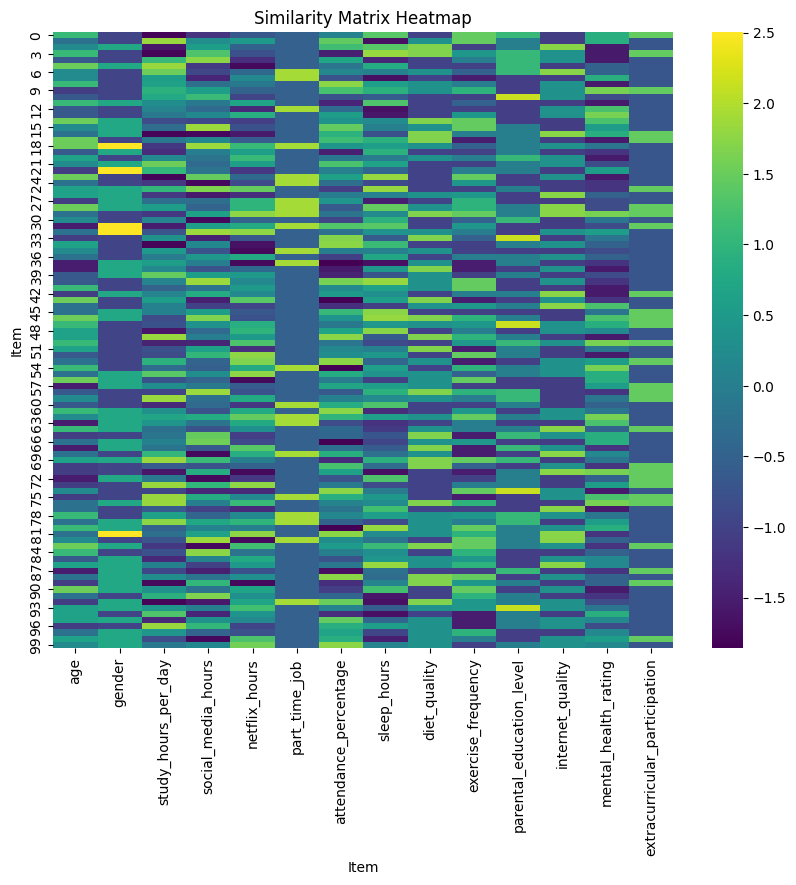

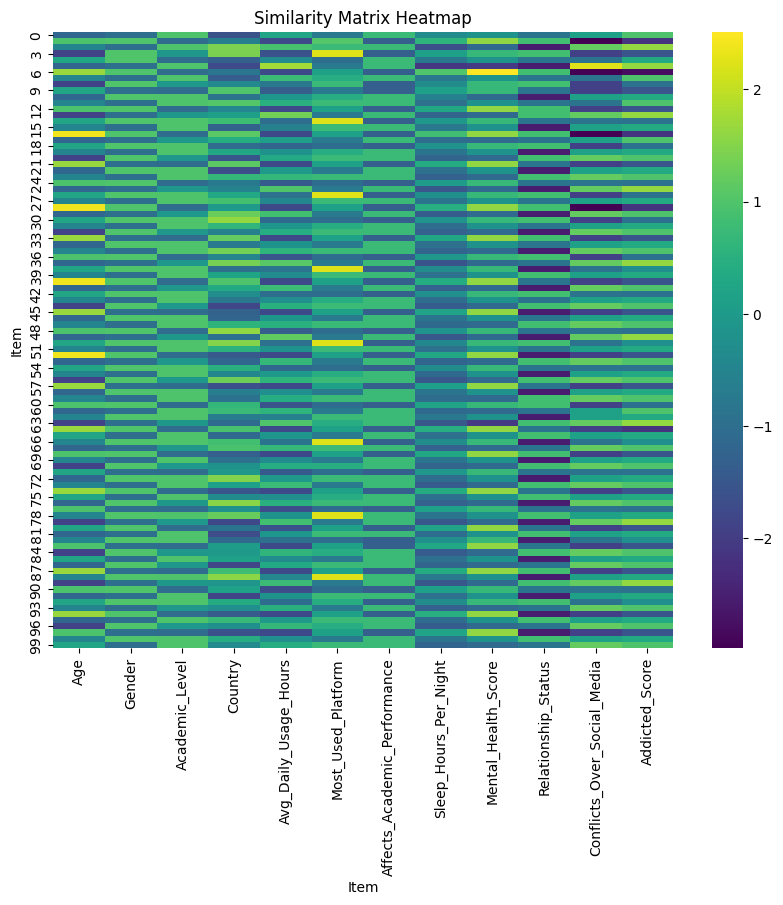

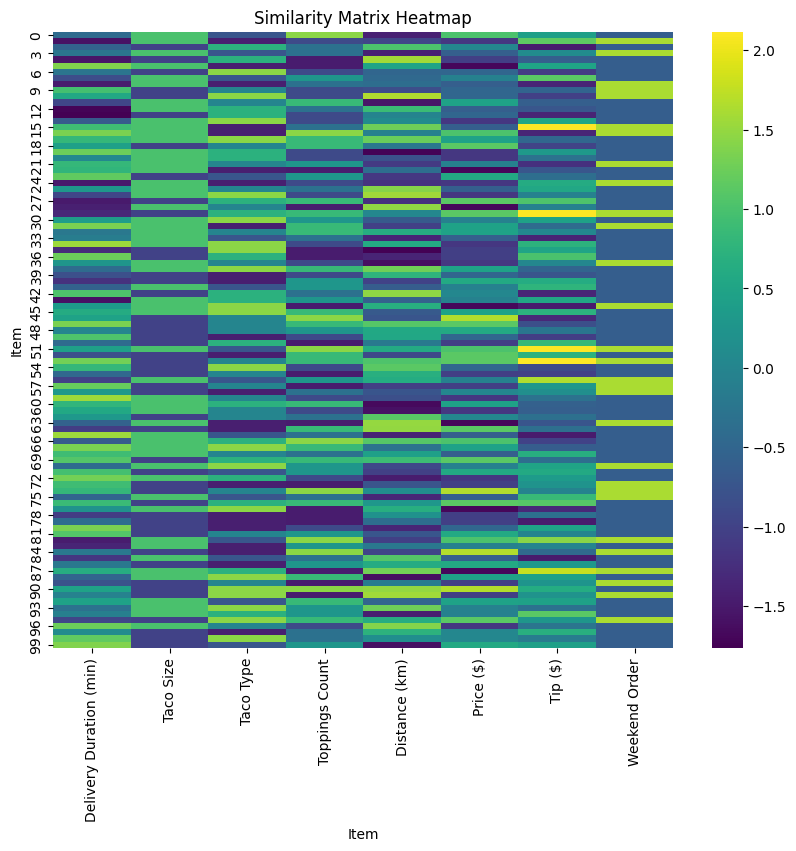

In [432]:
visualize_similarity_matrix(df1)
visualize_similarity_matrix(df2)
visualize_similarity_matrix(df3)
visualize_similarity_matrix(df4)
visualize_similarity_matrix(df5)

---

### 4. 🔁 **Implementasi K-Means (CPU & GPU)**

In [433]:
k = 3

In [434]:
from sklearn.cluster import KMeans as KMeans_CPU
from sklearn.metrics import silhouette_score as silhouette_score_cpu


kmeans_cpu = KMeans_CPU(n_clusters=k)

df1_np = df1.to_numpy()
df2_np = df2.to_numpy()
df3_np = df3.to_numpy()
df4_np = df4.to_numpy()
df5_np = df5.to_numpy()

# Clustering di CPU
df1_cluster_labels_cpu = kmeans_cpu.fit_predict(df1_np)
df2_cluster_labels_cpu = kmeans_cpu.fit_predict(df2_np)
df3_cluster_labels_cpu = kmeans_cpu.fit_predict(df3_np)
df4_cluster_labels_cpu = kmeans_cpu.fit_predict(df4_np)
df5_cluster_labels_cpu = kmeans_cpu.fit_predict(df5_np)

sil_score_df1_cpu = silhouette_score_cpu(df1_np, df1_cluster_labels_cpu)
print(f"Silhouette Score Dataset 1 (CPU): {sil_score_df1_cpu}")
sil_score_df2_cpu = silhouette_score_cpu(df2_np, df2_cluster_labels_cpu)
print(f"Silhouette Score Dataset 2 (CPU): {sil_score_df2_cpu}")
sil_score_df3_cpu = silhouette_score_cpu(df3_np, df3_cluster_labels_cpu)
print(f"Silhouette Score Dataset 3 (CPU): {sil_score_df3_cpu}")
sil_score_df4_cpu = silhouette_score_cpu(df4_np, df4_cluster_labels_cpu)
print(f"Silhouette Score Dataset 4 (CPU): {sil_score_df4_cpu}")
sil_score_df5_cpu = silhouette_score_cpu(df5_np, df5_cluster_labels_cpu)
print(f"Silhouette Score Dataset 5 (CPU): {sil_score_df5_cpu}")

Silhouette Score Dataset 1 (CPU): 0.47728604650490464
Silhouette Score Dataset 2 (CPU): 0.4430299814713303
Silhouette Score Dataset 3 (CPU): 0.06419840614103078
Silhouette Score Dataset 4 (CPU): 0.2446002469135529
Silhouette Score Dataset 5 (CPU): 0.17423188851533808


In [435]:
from cuml.cluster import KMeans as KMeans_GPU
from cuml.metrics.cluster import silhouette_score as silhouette_score_gpu


kmeans_gpu = KMeans_GPU(n_clusters=k, n_init='auto')

# Clustering di GPU
df1_cluster_labels_gpu = kmeans_gpu.fit_predict(df1)
df2_cluster_labels_gpu = kmeans_gpu.fit_predict(df2)
df3_cluster_labels_gpu = kmeans_gpu.fit_predict(df3)
df4_cluster_labels_gpu = kmeans_gpu.fit_predict(df4)
df5_cluster_labels_gpu = kmeans_gpu.fit_predict(df5)

sil_score_df1_gpu = silhouette_score_gpu(df1, df1_cluster_labels_gpu)
print(f"Silhouette Score Dataset 1 (GPU): {sil_score_df1_gpu}")
sil_score_df2_gpu = silhouette_score_gpu(df2, df2_cluster_labels_gpu)
print(f"Silhouette Score Dataset 2 (GPU): {sil_score_df2_gpu}")
sil_score_df3_gpu = silhouette_score_gpu(df3, df3_cluster_labels_gpu)
print(f"Silhouette Score Dataset 3 (GPU): {sil_score_df3_gpu}")
sil_score_df4_gpu = silhouette_score_gpu(df4, df4_cluster_labels_gpu)
print(f"Silhouette Score Dataset 4 (GPU): {sil_score_df4_gpu}")
sil_score_df5_gpu = silhouette_score_gpu(df5, df5_cluster_labels_gpu)
print(f"Silhouette Score Dataset 5 (GPU): {sil_score_df5_gpu}")

Silhouette Score Dataset 1 (GPU): 0.4951172160770149
Silhouette Score Dataset 2 (GPU): 0.43891237937972094
Silhouette Score Dataset 3 (GPU): 0.08634177334289041
Silhouette Score Dataset 4 (GPU): 0.2601117690456165
Silhouette Score Dataset 5 (GPU): 0.17425546425166713


---

### 5. ⚖️ **Komparasi**

In [436]:
def compare_silhouette_scores(cpu_scores, gpu_scores, dataset_names=None):
    """
    Membandingkan silhouette score hasil clustering CPU vs GPU.

    Args:
        cpu_scores (list): List silhouette score dari KMeans CPU.
        gpu_scores (list): List silhouette score dari KMeans GPU.
        dataset_names (list, optional): Nama-nama dataset.
    """
    if dataset_names is None:
        dataset_names = [f"Dataset {i+1}" for i in range(len(cpu_scores))]

    for i, (cpu, gpu) in enumerate(zip(cpu_scores, gpu_scores)):
        diff = gpu - cpu
        percent = abs(100 * diff / cpu) if cpu != 0 else float('inf')
        if abs(diff) < 1e-8:
          print(f"{dataset_names[i]}: Skor sama (CPU & GPU = {cpu:.6f})")
        elif diff > 0:
          print(f"{dataset_names[i]}: GPU lebih unggul {percent:.2f}% (GPU: {gpu:.6f}, CPU: {cpu:.6f})")
        else:
          print(f"{dataset_names[i]}: CPU lebih unggul {percent:.2f}% (CPU: {cpu:.6f}, GPU: {gpu:.6f})")

In [437]:
cpu_scores = [
    sil_score_df1_cpu,
    sil_score_df2_cpu,
    sil_score_df3_cpu,
    sil_score_df4_cpu,
    sil_score_df5_cpu,
]
gpu_scores = [
    sil_score_df1_gpu,
    sil_score_df2_gpu,
    sil_score_df3_gpu,
    sil_score_df4_gpu,
    sil_score_df5_gpu,
]
dataset_names = [f"Dataset {i+1}" for i in range(5)]

compare_silhouette_scores(cpu_scores, gpu_scores, dataset_names)

Dataset 1: GPU lebih unggul 3.74% (GPU: 0.495117, CPU: 0.477286)
Dataset 2: CPU lebih unggul 0.93% (CPU: 0.443030, GPU: 0.438912)
Dataset 3: GPU lebih unggul 34.49% (GPU: 0.086342, CPU: 0.064198)
Dataset 4: GPU lebih unggul 6.34% (GPU: 0.260112, CPU: 0.244600)
Dataset 5: GPU lebih unggul 0.01% (GPU: 0.174255, CPU: 0.174232)


---

### 6. 🧪 **Evaluasi**

- mencari optimal k dengan elbow method

In [438]:
def kmeans_metrics_cpu(X, max_k=12, random_state=42, max_iter=1000):
    inertia = []
    silhouette_scores = []
    k_values = range(2, max_k + 1)
    for k in k_values:
        kmeans = KMeans_CPU(n_clusters=k, random_state=random_state, max_iter=max_iter)
        cluster_labels = kmeans.fit_predict(X)
        sil_score = silhouette_score_cpu(X, cluster_labels)
        silhouette_scores.append(sil_score)
        inertia.append(kmeans.inertia_)
    return k_values, inertia, silhouette_scores

In [439]:
def kmeans_metrics_gpu(X_cudf, max_k=12, random_state=42, max_iter=1000):
    inertia = []
    silhouette_scores = []
    k_values = range(2, max_k + 1)
    for k in k_values:
        kmeans = KMeans_GPU(n_clusters=k, random_state=random_state, max_iter=max_iter, n_init='auto')
        cluster_labels = kmeans.fit_predict(X_cudf)
        # Konversi ke numpy untuk silhouette_score scikit-learn
        cluster_labels_np = cluster_labels.to_numpy()
        X_np = X_cudf.to_numpy()
        sil_score = silhouette_score_cpu(X_np, cluster_labels_np)
        silhouette_scores.append(sil_score)
        inertia.append(float(kmeans.inertia_))  # cuML inertia_ bertipe cupy scalar
    return k_values, inertia, silhouette_scores


In [440]:
def plot_elbow_and_silhouette(k_values, inertia, silhouette_scores, title_suffix="CPU"):
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(k_values, inertia, marker='o')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.xticks(k_values)
    plt.title(f'Elbow Method - {title_suffix}')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(k_values, silhouette_scores, marker='o', color='orange')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title(f'Silhouette Scores for Different k Values - {title_suffix}')
    plt.xticks(k_values)
    plt.grid(True)

    plt.tight_layout()
    plt.show()

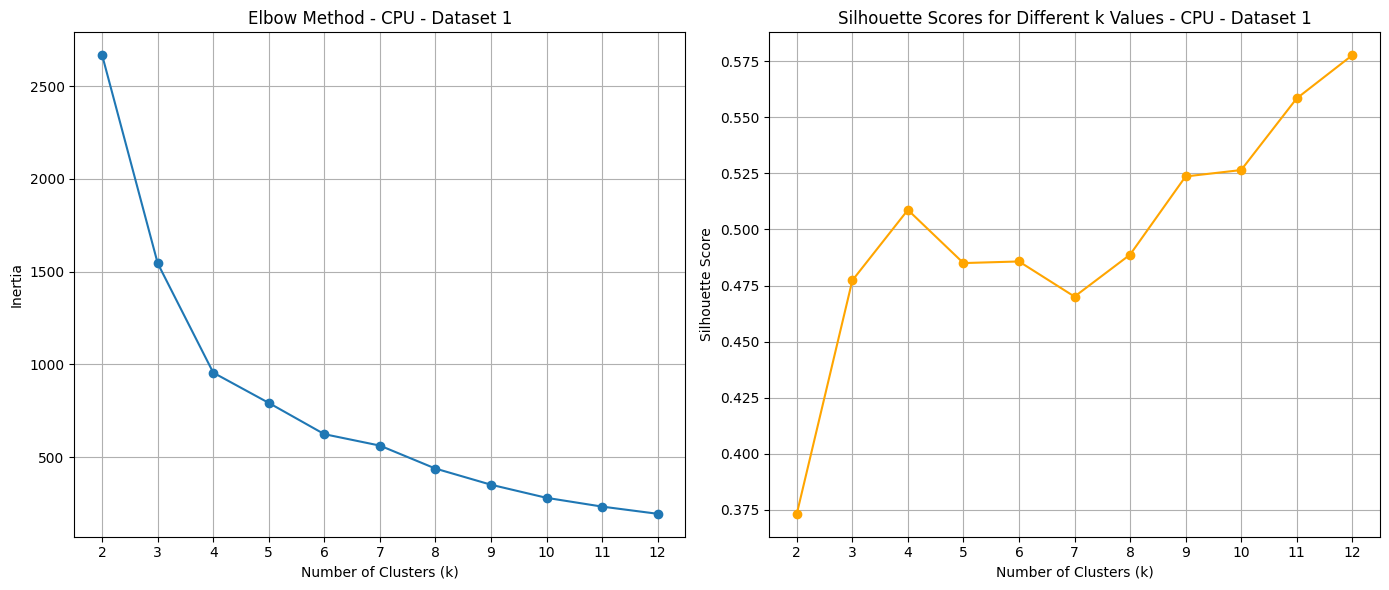

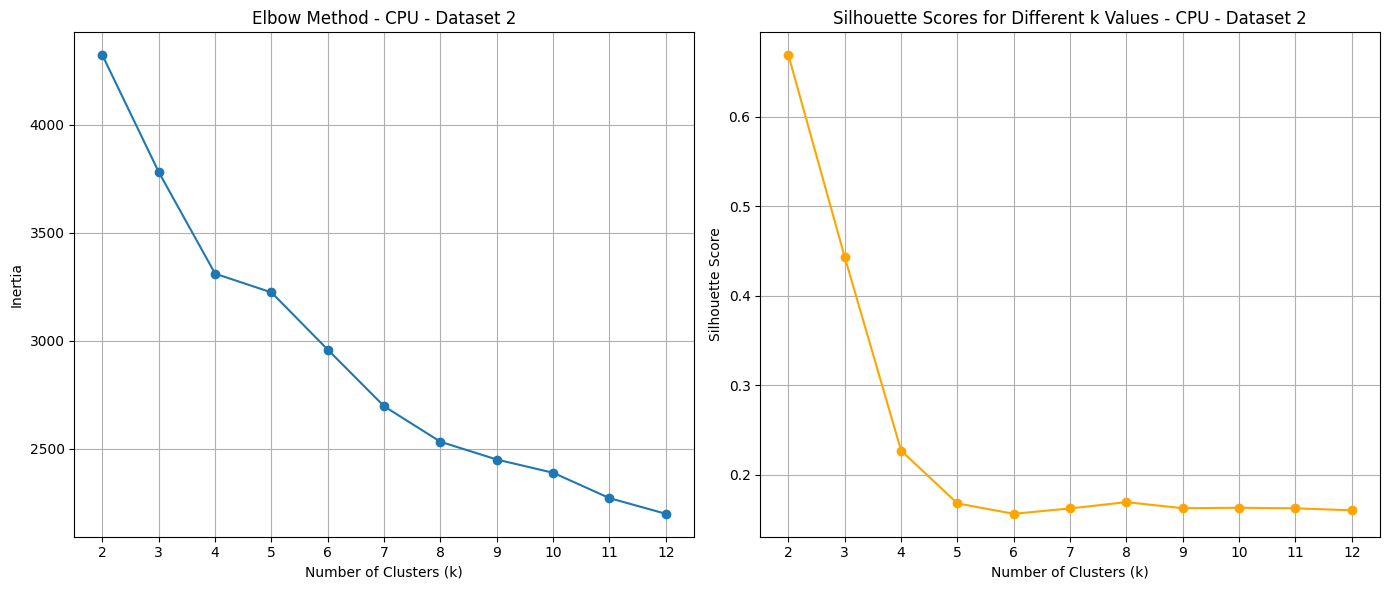

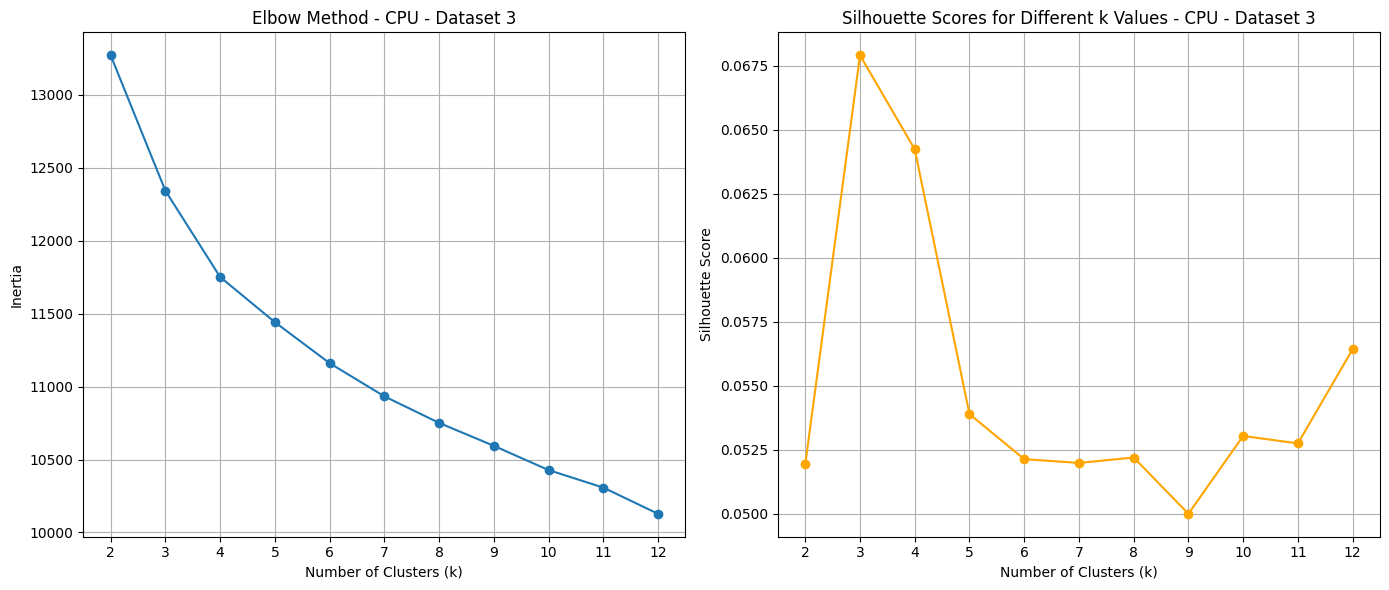

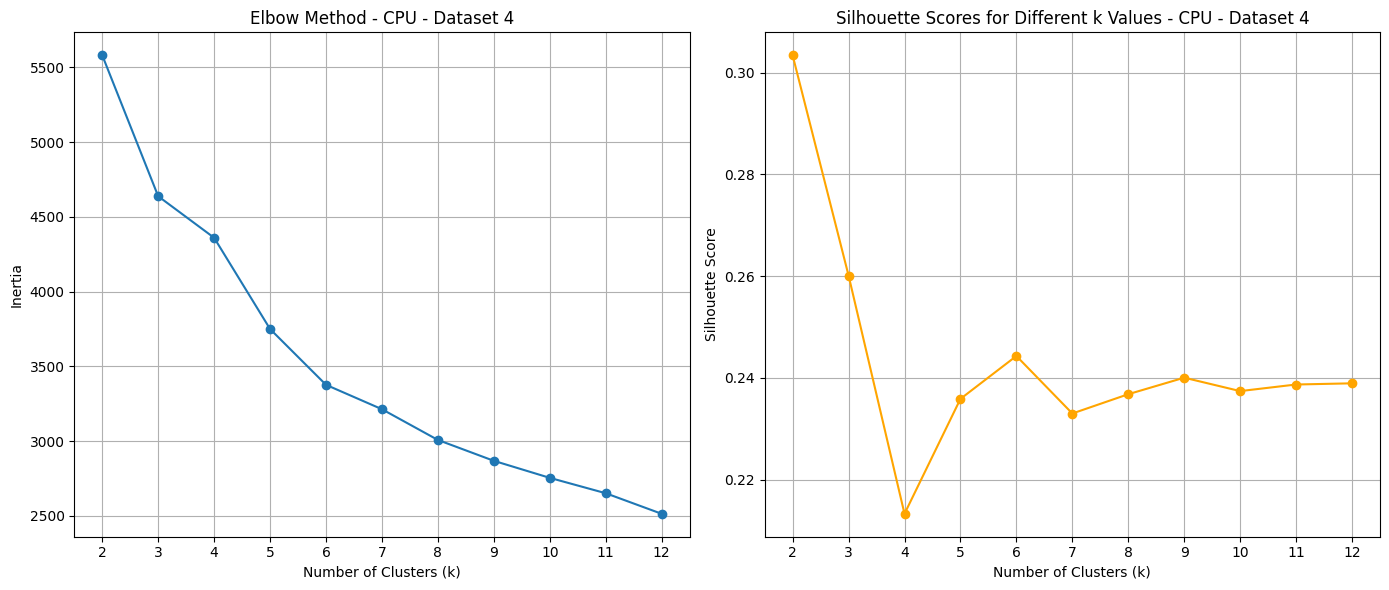

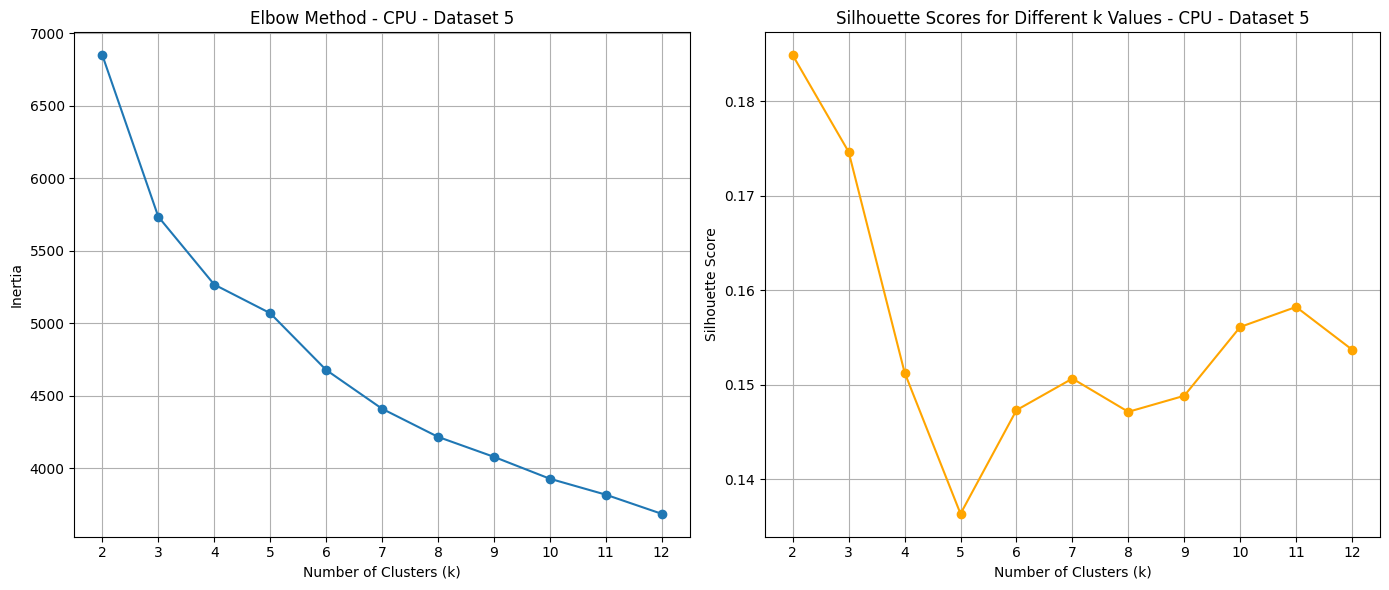

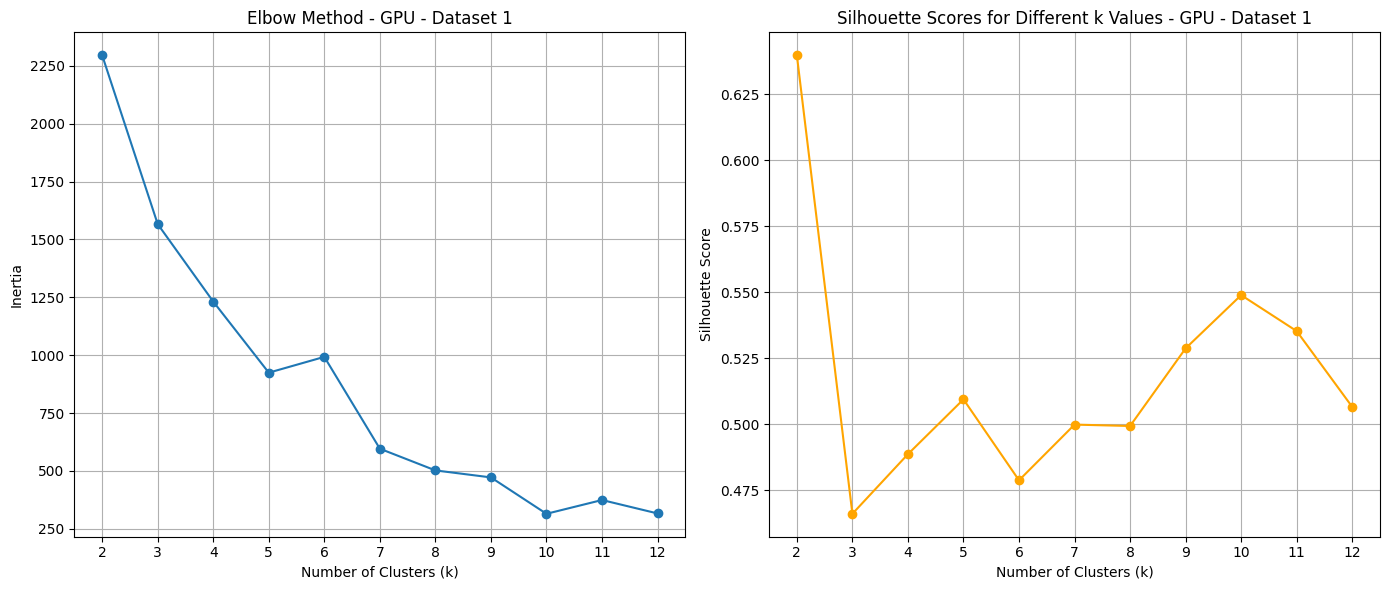

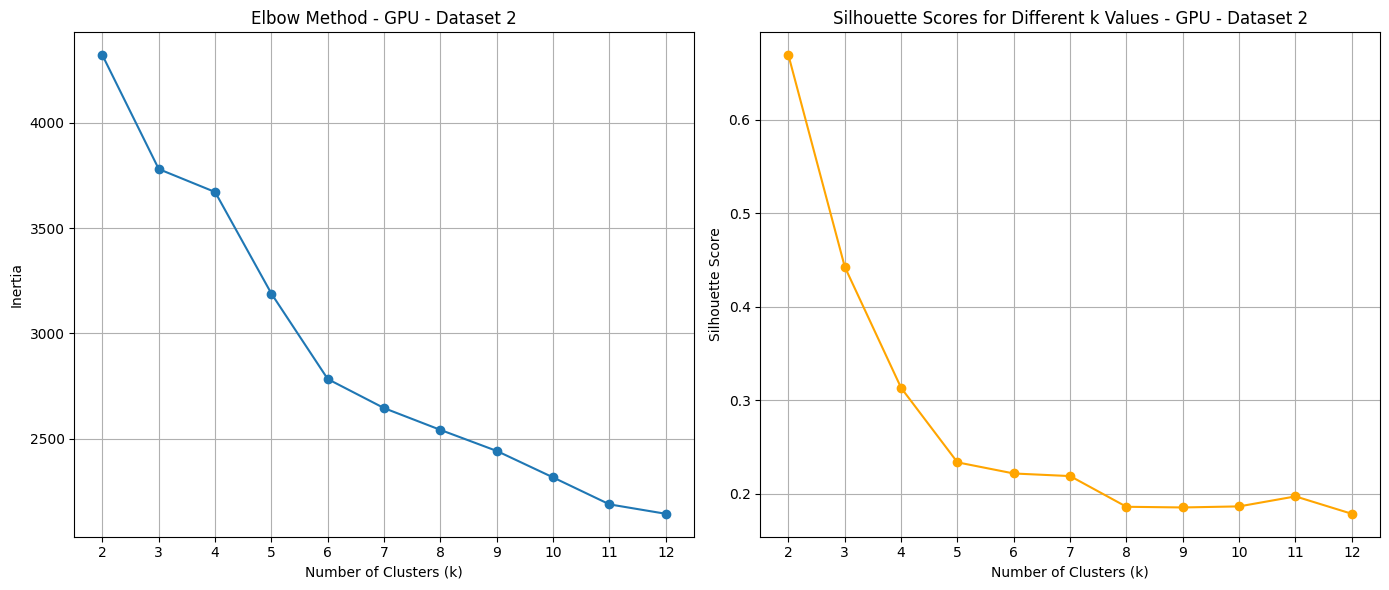

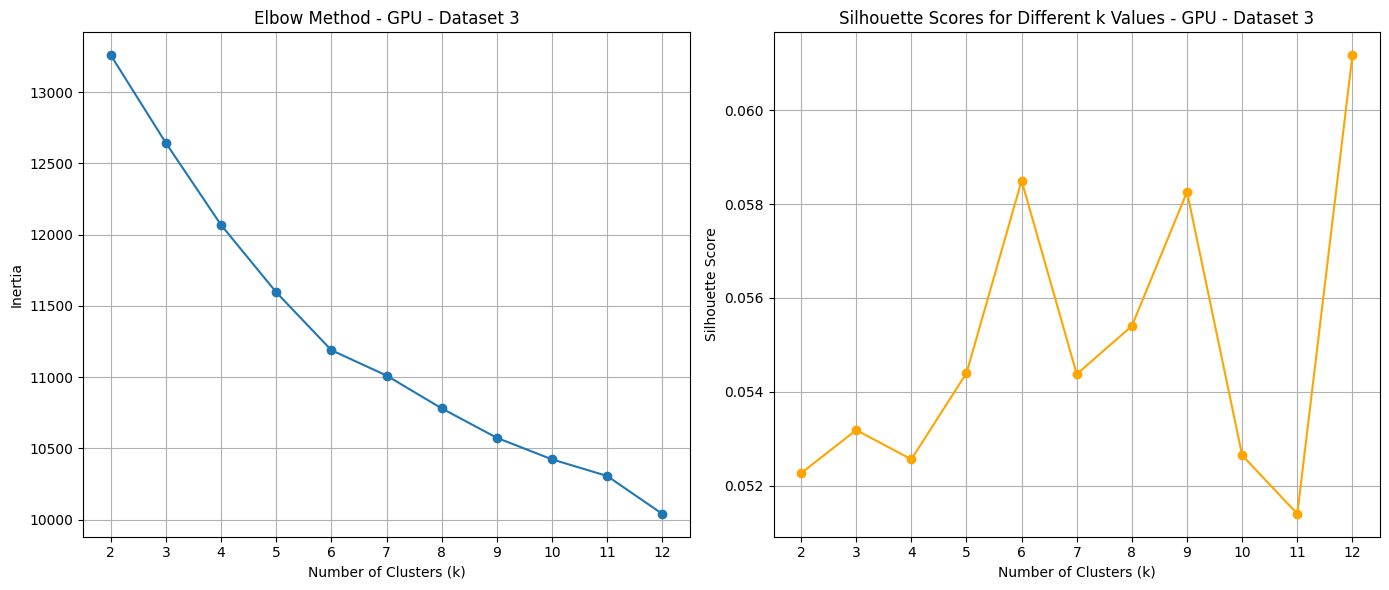

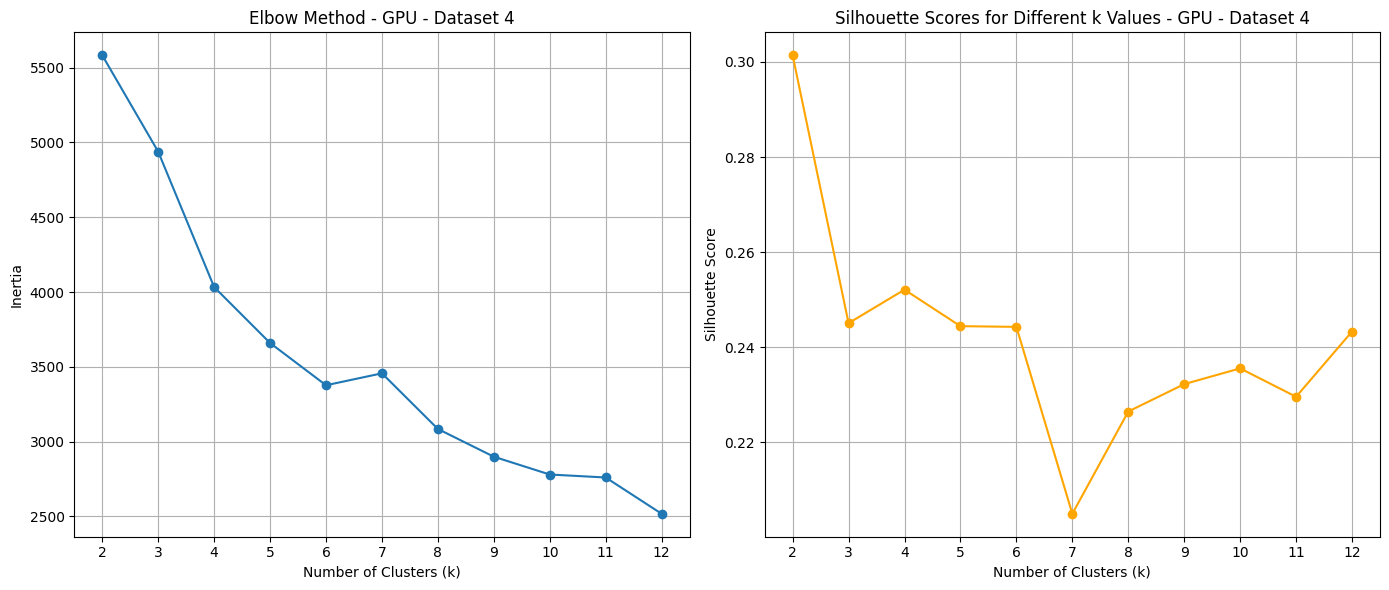

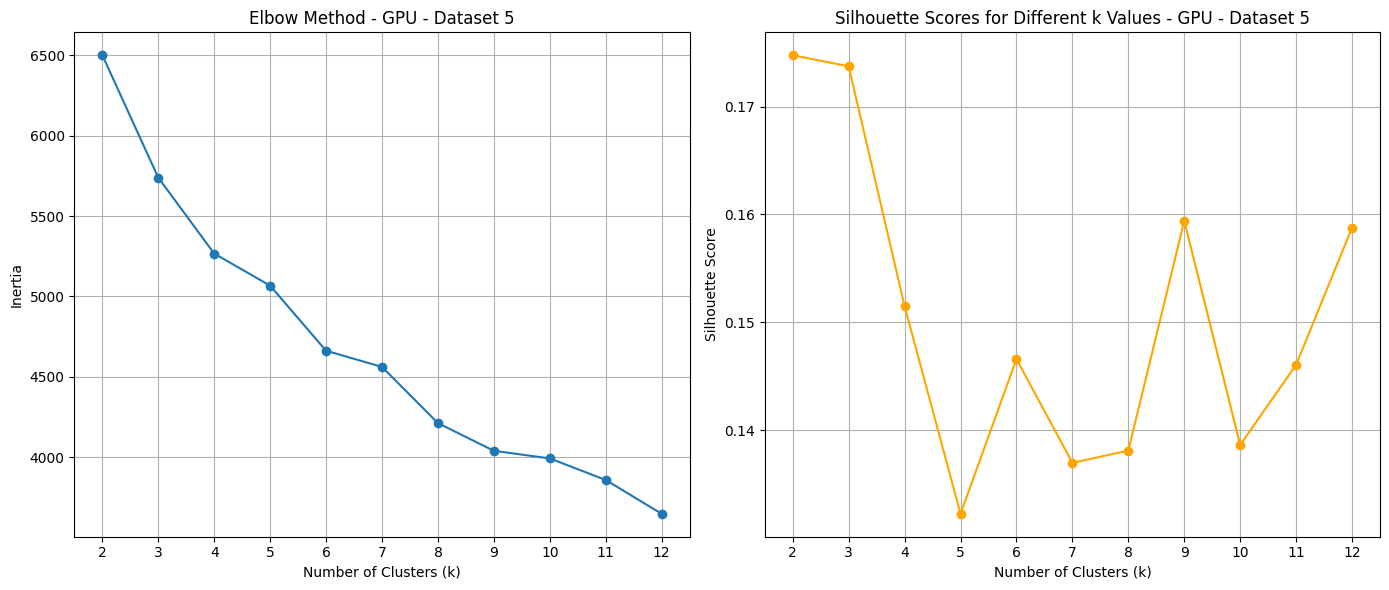

In [441]:
# Untuk CPU
for i, df_np in enumerate([df1_np, df2_np, df3_np, df4_np, df5_np], start=1):
    k_values, inertia_cpu, sil_cpu = kmeans_metrics_cpu(df_np, max_k=12)
    plot_elbow_and_silhouette(
        k_values, inertia_cpu, sil_cpu,
        title_suffix=f"CPU - Dataset {i}"
    )

# Untuk GPU
for i, df_cudf in enumerate([df1, df2, df3, df4, df5], start=1):
    k_values, inertia_gpu, sil_gpu = kmeans_metrics_gpu(df_cudf, max_k=12)
    plot_elbow_and_silhouette(
        k_values, inertia_gpu, sil_gpu,
        title_suffix=f"GPU - Dataset {i}"
    )


In [448]:
k_optimal_df1_cpu = 4
k_optimal_df2_cpu = 3
k_optimal_df3_cpu = 3
k_optimal_df4_cpu = 6
k_optimal_df5_cpu = 3

k_optimal_df1_gpu = 2
k_optimal_df2_gpu = 2
k_optimal_df3_gpu = 12
k_optimal_df4_gpu = 2
k_optimal_df5_gpu = 2

In [449]:
kmeans_optimal_df1_cpu = KMeans_CPU(n_clusters=k_optimal_df1_cpu, random_state=42, max_iter=1000)
kmeans_optimal_df2_cpu = KMeans_CPU(n_clusters=k_optimal_df2_cpu, random_state=42, max_iter=1000)
kmeans_optimal_df3_cpu = KMeans_CPU(n_clusters=k_optimal_df3_cpu, random_state=42, max_iter=1000)
kmeans_optimal_df4_cpu = KMeans_CPU(n_clusters=k_optimal_df4_cpu, random_state=42, max_iter=1000)
kmeans_optimal_df5_cpu = KMeans_CPU(n_clusters=k_optimal_df5_cpu, random_state=42, max_iter=1000)

kmeans_optimal_df1_gpu = KMeans_GPU(n_clusters=k_optimal_df1_gpu, random_state=42, max_iter=1000, n_init='auto')
kmeans_optimal_df2_gpu = KMeans_GPU(n_clusters=k_optimal_df2_gpu, random_state=42, max_iter=1000, n_init='auto')
kmeans_optimal_df3_gpu = KMeans_GPU(n_clusters=k_optimal_df3_gpu, random_state=42, max_iter=1000, n_init='auto')
kmeans_optimal_df4_gpu = KMeans_GPU(n_clusters=k_optimal_df4_gpu, random_state=42, max_iter=1000, n_init='auto')
kmeans_optimal_df5_gpu = KMeans_GPU(n_clusters=k_optimal_df5_gpu, random_state=42, max_iter=1000, n_init='auto')

In [450]:
df1_cluster_labels_optimal_cpu = kmeans_optimal_df1_cpu.fit_predict(df1_np)
df2_cluster_labels_optimal_cpu = kmeans_optimal_df2_cpu.fit_predict(df2_np)
df3_cluster_labels_optimal_cpu = kmeans_optimal_df3_cpu.fit_predict(df3_np)
df4_cluster_labels_optimal_cpu = kmeans_optimal_df4_cpu.fit_predict(df4_np)
df5_cluster_labels_optimal_cpu = kmeans_optimal_df5_cpu.fit_predict(df5_np)

sil_score_df1_optimal_cpu = silhouette_score_cpu(df1_np, df1_cluster_labels_optimal_cpu)
print(f"Silhouette Score Dataset 1 (CPU): {sil_score_df1_optimal_cpu}")
sil_score_df2_optimal_cpu = silhouette_score_cpu(df2_np, df2_cluster_labels_optimal_cpu)
print(f"Silhouette Score Dataset 2 (CPU): {sil_score_df2_optimal_cpu}")
sil_score_df3_optimal_cpu = silhouette_score_cpu(df3_np, df3_cluster_labels_optimal_cpu)
print(f"Silhouette Score Dataset 3 (CPU): {sil_score_df3_optimal_cpu}")
sil_score_df4_optimal_cpu = silhouette_score_cpu(df4_np, df4_cluster_labels_optimal_cpu)
print(f"Silhouette Score Dataset 4 (CPU): {sil_score_df4_optimal_cpu}")
sil_score_df5_optimal_cpu = silhouette_score_cpu(df5_np, df5_cluster_labels_optimal_cpu)
print(f"Silhouette Score Dataset 5 (CPU): {sil_score_df5_optimal_cpu}")

Silhouette Score Dataset 1 (CPU): 0.5087269001367357
Silhouette Score Dataset 2 (CPU): 0.4430801483909924
Silhouette Score Dataset 3 (CPU): 0.0679061479428403
Silhouette Score Dataset 4 (CPU): 0.24428915132690648
Silhouette Score Dataset 5 (CPU): 0.17462322601718336


In [451]:
df1_cluster_labels_optimal_gpu = kmeans_optimal_df1_gpu.fit_predict(df1)
df2_cluster_labels_optimal_gpu = kmeans_optimal_df2_gpu.fit_predict(df2)
df3_cluster_labels_optimal_gpu = kmeans_optimal_df3_gpu.fit_predict(df3)
df4_cluster_labels_optimal_gpu = kmeans_optimal_df4_gpu.fit_predict(df4)
df5_cluster_labels_optimal_gpu = kmeans_optimal_df5_gpu.fit_predict(df5)

sil_score_df1_optimal_gpu = silhouette_score_gpu(df1, df1_cluster_labels_optimal_gpu)
print(f"Silhouette Score Dataset 1 (GPU): {sil_score_df1_optimal_gpu}")
sil_score_df2_optimal_gpu = silhouette_score_gpu(df2, df2_cluster_labels_optimal_gpu)
print(f"Silhouette Score Dataset 2 (GPU): {sil_score_df2_optimal_gpu}")
sil_score_df3_optimal_gpu = silhouette_score_gpu(df3, df3_cluster_labels_optimal_gpu)
print(f"Silhouette Score Dataset 3 (GPU): {sil_score_df3_optimal_gpu}")
sil_score_df4_optimal_gpu = silhouette_score_gpu(df4, df4_cluster_labels_optimal_gpu)
print(f"Silhouette Score Dataset 4 (GPU): {sil_score_df4_optimal_gpu}")
sil_score_df5_optimal_gpu = silhouette_score_gpu(df5, df5_cluster_labels_optimal_gpu)
print(f"Silhouette Score Dataset 5 (GPU): {sil_score_df5_optimal_gpu}")

Silhouette Score Dataset 1 (GPU): 0.6398511890775602
Silhouette Score Dataset 2 (GPU): 0.6688286868041285
Silhouette Score Dataset 3 (GPU): 0.06116511438784518
Silhouette Score Dataset 4 (GPU): 0.3013944238089398
Silhouette Score Dataset 5 (GPU): 0.17476149969187588


In [452]:
cpu_scores_optimal = [
    sil_score_df1_optimal_cpu,
    sil_score_df2_optimal_cpu,
    sil_score_df3_optimal_cpu,
    sil_score_df4_optimal_cpu,
    sil_score_df5_optimal_cpu,
]
gpu_scores_optimal = [
    sil_score_df1_optimal_gpu,
    sil_score_df2_optimal_gpu,
    sil_score_df3_optimal_gpu,
    sil_score_df4_optimal_gpu,
    sil_score_df5_optimal_gpu,
]
dataset_names = [f"Dataset (optimal) {i+1}" for i in range(5)]

compare_silhouette_scores(cpu_scores_optimal, gpu_scores_optimal, dataset_names)

Dataset (optimal) 1: GPU lebih unggul 25.77% (GPU: 0.639851, CPU: 0.508727)
Dataset (optimal) 2: GPU lebih unggul 50.95% (GPU: 0.668829, CPU: 0.443080)
Dataset (optimal) 3: CPU lebih unggul 9.93% (CPU: 0.067906, GPU: 0.061165)
Dataset (optimal) 4: GPU lebih unggul 23.38% (GPU: 0.301394, CPU: 0.244289)
Dataset (optimal) 5: GPU lebih unggul 0.08% (GPU: 0.174761, CPU: 0.174623)


---

### 7. 📈 **Visualisasi Cluster**